# Uploading Data From Kaggle

In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Classifier/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download dqmonn/zalando-store-crawl
! unzip zalando-store-crawl.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: zalando/zalando/sweatshirt-female/NAA21J00K-K11@8.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00L-C11@8.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00L-H11@7.1.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00L-Q11@8.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00M-G11@13.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00N-C11@10.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00O-Q11@9.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00P-N11@5.1.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00Q-Q11@10.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00U-A11@4.jpg  
  inflating: zalando/zalando/sweatshirt-female/NAA21J00V-P11@4.jpg  
  inflating: zalando/zalando/sweatshirt-female/NE221J007-Q11@1.1.jpg  
  inflating: zalando/zalando/sweatshirt-female/NE221J00C-A11@1.1.jpg  
  inflating: zalando/zalando/sweatshirt-femal

# Import Libraries

In [ ]:
from torchvision import transforms, datasets, models
import torch 
from torch import optim, cuda 
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image 
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import pathlib

import torch
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np

import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, sampler, random_split
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [ ]:
data_dir = "/content/zalando/zalando"

In [ ]:
print(os.listdir(data_dir))

['sweatshirt', 'hoodies-female', 'sweatshirt-female', 'hoodies', 'longsleeve', 'shirt']


### Let's check the distribution of the data

In [ ]:
categories = os.listdir(data_dir)

count_graph = pd.DataFrame(index = [i for i in categories],
                           data = [len(os.listdir(data_dir + "/" + name))
                                  for name in categories],
                           columns = ["number of images"])
count_graph.head()

,number of images
sweatshirt,3886
hoodies-female,1210
sweatshirt-female,2456
hoodies,2144
longsleeve,1700


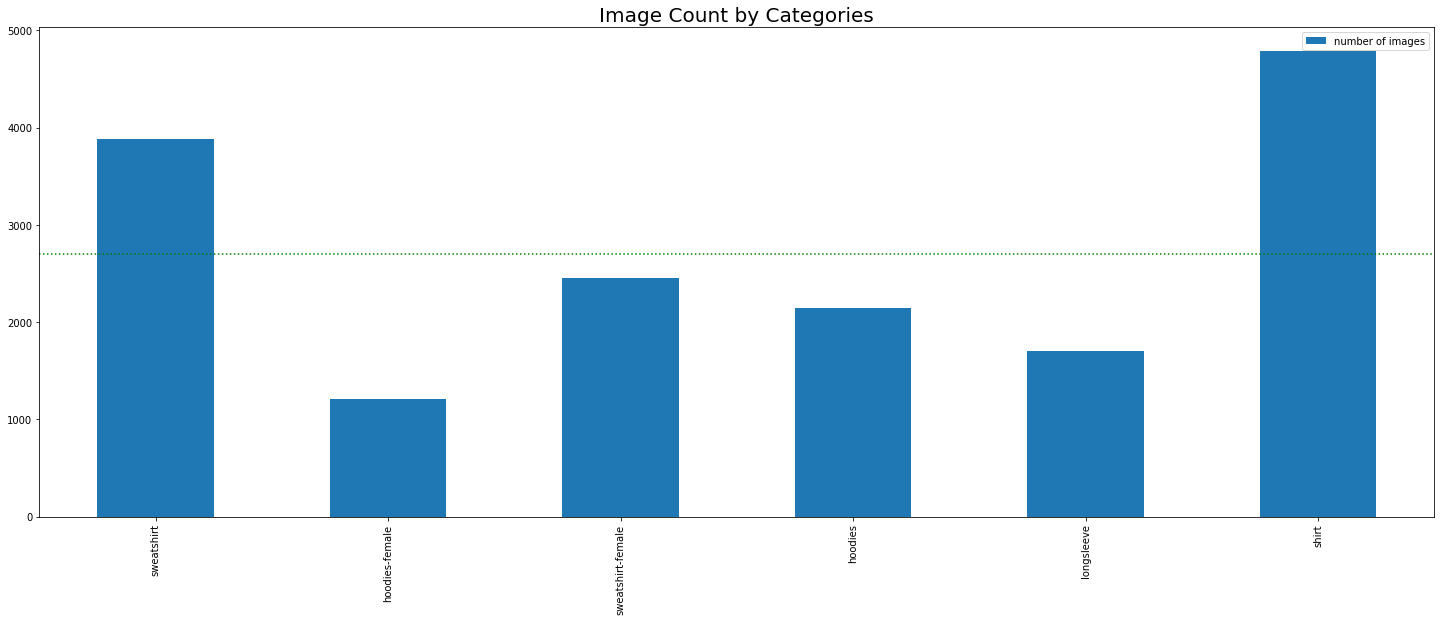

Mean Value of All Categories: 2697.6666666666665


In [ ]:
fig = count_graph.plot(kind = "bar", figsize = (25,9))
mean_of_pictures = count_graph["number of images"].mean()
fig.axhline(mean_of_pictures, color = "g", linestyle = ":", label = "Mean of Pictures")
plt.title("Image Count by Categories", fontsize = 20)
plt.show()
print("Mean Value of All Categories:", mean_of_pictures)

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


###Adding Gaussian Noise and Training

In [ ]:
# Defining a function for gaussian noise
def add_gaussian_noise(tensor):
  noise = torch.randn(tensor.size()) * 0.5
  return tensor + noise
# This code randomly adds 0 to 0.5 density noise to the images

img_transforms = {
    "train" :
    transforms.Compose([
        transforms.RandomResizedCrop(size = (300, 600), scale = (0.2, 0.8)),
        transforms.RandomRotation(degrees = (-15, 15)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 299),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_gaussian_noise(x)), # Implementation of the Gaussian Noise Function
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test" : 
     transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data = datasets.ImageFolder(root = data_dir, transform = img_transforms["train"])

train_data_len = int(len(data)*0.7)
valid_data_len = int((len(data) - train_data_len))


print("Train Data Length :", train_data_len)
print("Validation Data Length :", valid_data_len)




train_data, val_data= random_split(data, [train_data_len, valid_data_len])

train_data.dataset.transform = img_transforms['train']
val_data.dataset.transform = img_transforms['test']


print("Length of train data: ", len(train_data), "\n",
      "Length of val data:",  len(val_data))

batch = 32
train_loader = DataLoader(dataset = train_data, batch_size=batch, shuffle=True)
val_loader = DataLoader(dataset = val_data, batch_size=batch, shuffle=True)


dataloaders = {"train":train_loader, "val":val_loader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

trainiter = iter(train_loader)
features, labels = next(trainiter) 
print(features.shape, labels.shape)
print(data_sizes)

# Training
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

       
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

               
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
               
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

   
    model.load_state_dict(best_model_wts)
    return model

# Model
!pip install timm
import timm
model_xception = timm.create_model('xception', pretrained=True)

learning_rate = 0.1
optimizer = optim.SGD(model_xception.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1)

model_xception.cuda()
np.seterr(divide='ignore', invalid='ignore')
base_model_xception = train_model(model_xception, criterion, optimizer, exp_lr_scheduler,num_epochs=10)

Train Data Length : 11326
Validation Data Length : 4854
Length of train data:  11326 
 Length of val data: 4854
torch.Size([32, 3, 299, 299]) torch.Size([32])
{'train': 11326, 'val': 4854}
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.8 MB/s eta 0:00:00


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch 1/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.6915 | train Accuracy: 0.7071


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4718 | val Accuracy: 0.7392 | Kappa Score: 0.6623
Val loss Decreased from inf to 0.4718 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3568 | train Accuracy: 0.7928


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4248 | val Accuracy: 0.7365 | Kappa Score: 0.6656
Val loss Decreased from 0.4718 to 0.4248 
Saving Weights... 

Epoch 3/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3095 | train Accuracy: 0.8223


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4270 | val Accuracy: 0.7441 | Kappa Score: 0.6767

Epoch 4/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3031 | train Accuracy: 0.8266


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4355 | val Accuracy: 0.7412 | Kappa Score: 0.6739

Epoch 5/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3049 | train Accuracy: 0.8269


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4281 | val Accuracy: 0.7429 | Kappa Score: 0.6765

Epoch 6/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3065 | train Accuracy: 0.8223


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4318 | val Accuracy: 0.7410 | Kappa Score: 0.6727

Epoch 7/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3024 | train Accuracy: 0.8282


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4451 | val Accuracy: 0.7359 | Kappa Score: 0.6647

Epoch 8/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3033 | train Accuracy: 0.8253


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4273 | val Accuracy: 0.7429 | Kappa Score: 0.6752

Epoch 9/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3021 | train Accuracy: 0.8272


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4291 | val Accuracy: 0.7429 | Kappa Score: 0.6744

Epoch 10/10
----------


train:   0%|          | 0/354 [00:00<?, ?it/s]

train Loss: 0.3030 | train Accuracy: 0.8266


val:   0%|          | 0/152 [00:00<?, ?it/s]

val Loss: 0.4311 | val Accuracy: 0.7406 | Kappa Score: 0.6721

Training complete in 101m 47s
Best val loss: 0.4248
